In [0]:
!pip install imutils
!pip install PyDrive
!pip install pydrive --upgrade

Requirement already up-to-date: pydrive in /usr/local/lib/python3.6/dist-packages (1.3.1)


###  Initialization

In [0]:
import numpy as np
import math as m
import h5py
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import imutils
import skimage
from skimage import io
from skimage import transform
from matplotlib import pyplot as plt


from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

### Mounting google drive with this Colab Notebook

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp4cgwo1aw/pubring.gpg' created
gpg: /tmp/tmp4cgwo1aw/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls
#Code to download CelebA hdf5 dataset from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileId = drive.CreateFile({'id': '1D7MYVPbn4JSVRZMQbQogfW2anmXLCKY7'})

print(fileId['title'])  # CelebA Dataset
fileId.GetContentFile('Syn_data_medium.zip')  # Save Drive file as a local file

adc.json  drive  sample_data
Syn_data_medium.zip


In [0]:
# Unzip synthetic data
import zipfile
zip_ref = zipfile.ZipFile('Syn_data_medium.zip', 'r')
zip_ref.extractall('SyntheticData')
zip_ref.close()

In [0]:
!ls 
!ls sample_data/

adc.json  drive  sample_data  Syn_data_medium.zip  SyntheticData
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [0]:
image_list = []
normal_list = []
albedo_list = []
mask = []
light = []
cwd = os.getcwd()

# generating list for image, albedo, normal, lighting SH and mask in a similar order
for i in range(0,10):
    folder = str(i+1).zfill(4)
    print(folder)
    path = cwd + '/SyntheticData/data/' + folder + '/'
    #print(path)
    addrs = os.walk(path)
    for root, dirs, filename in addrs:
        filename.sort() 
        for file in filename:
            if (file.endswith(".png") and 'face' in file):
                im=io.imread(os.path.join(root, file))
                image_list.append(skimage.transform.resize(im,(128,128)))           
            elif (file.endswith(".png") and 'albedo' in file):
                im=io.imread(os.path.join(root, file))
                albedo_list.append(skimage.transform.resize(im,(128,128)))   
            elif (file.endswith(".png") and 'normal' in file):
                im=io.imread(os.path.join(root, file))
                normal_list.append(skimage.transform.resize(im,(128,128)))
            elif (file.endswith(".png") and 'mask' in file):
                im=io.imread(os.path.join(root, file))
                mask.append(skimage.transform.resize(im,(128,128)))           
            elif (file.endswith(".txt")):
                text = open(os.path.join(root, file),"r") 
                data = text.read()
                data = data.split()
                light.append(data)         

#print(len(image_list))
# converting list to array 
image_list = np.array(image_list)
albedo_list = np.array(albedo_list)
normal_list = np.array(normal_list)
light = np.array(light)
mask = np.array(mask)

0001


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0002
0003
0004
0005
0006
0007
0008
0009
0010


In [0]:
# converting to flot32 type array
image_list = np.asarray(image_list).astype(np.float32)
normal_list = np.asarray(normal_list).astype(np.float32)
albedo_list = np.asarray(albedo_list).astype(np.float32)
light = np.asarray(light).astype(np.float32)
mask = np.asarray(mask).astype(np.float32)

In [0]:
print(image_list.shape)
print(albedo_list.shape)
print(normal_list.shape)
print(light.shape)
print(mask.shape)

(3000, 128, 128, 3)
(3000, 128, 128, 3)
(3000, 128, 128, 3)
(3000, 27)
(3000, 128, 128, 3)


Text(0.5,1,'Mask')

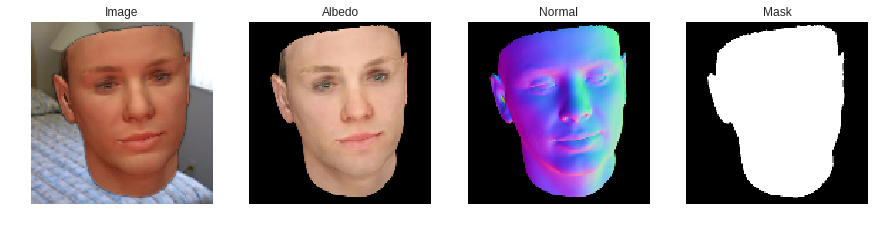

In [0]:
# plotting image, albedo, normal and mask for one face from synthetic dataset 
fig, axs = plt.subplots(1,4,figsize=(15,5))

img = image_list[5]
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Image')

img = albedo_list[5]
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Albedo')

img = normal_list[5]
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Normal')

img = mask[5]
axs[3].imshow(img)
axs[3].axis('off')
axs[3].set_title('Mask')

In [0]:
normal_label=np.asarray([1 for i in range(normal_list.shape[0])])
albedo_label=np.asarray([1 for i in range(albedo_list.shape[0])])
mask_label=np.asarray([1 for i in range(mask.shape[0])])

In [0]:
n_total = image_list.shape[0]
train_min_index = int(n_total * 0)
train_max_index = int(n_total * 0.8)
test_min_index = int((n_total * 0.8))
test_max_index = int(n_total * 1)

train_data = {"images": image_list[:train_max_index], "normals": normal_list[:train_max_index], "albedos": albedo_list[:train_max_index],\
              "lightings": light[:train_max_index], "mask": mask[:train_max_index], "nlabel": normal_label[:train_max_index],\
              "alabel": albedo_label[:train_max_index], "mlabel": mask_label[:train_max_index]}

test_data = {"images": image_list[test_min_index:], "normals": normal_list[test_min_index:], "albedos": albedo_list[test_min_index:],\
             "lightings": light[test_min_index:], "mask": mask[test_min_index:], "nlabel": normal_label[test_min_index:],\
             "alabel": albedo_label[test_min_index:], "mlabel": mask_label[test_min_index:]}

In [0]:
print(train_data["images"].shape)
print(test_data["images"].shape)

(2400, 128, 128, 3)
(600, 128, 128, 3)


In [0]:
def input_fn(data):
    # Input function for tf.estimator
    '''      
        Input: train, validation or test data
        
        Output: features and labels as dictionary
    '''
    
    features = {"images":data['images'],"mask":data['mask']}
    labels = {"normals":data['normals'], "albedos":data['albedos'], "lightings":data['lightings'],
              "nlabel":data['nlabel'], "alabel":data['alabel'], "mlabel":data['mlabel']}
    
    return features, labels

In [0]:
def model_fn(features, labels, mode, params):
    # The network architecture along with loss functions 
    '''
        Input: Features(i.e. images and corresponding masks)
               Labels(i.e. Normal, Albedo, lighting and their labels)
               Mode(one of tf.estimator.ModeKeys.{TRAIN, PREDICT, EVAL})
               Parameters(A dictionary containing all the hyperparameters for the training
               
        Output:ModelFnOps for Estimator API.
    '''
    def NormLayer(bottom_layer):
        # Normalisation layer(Helper Method)

        sz=bottom_layer.shape
        nor=bottom_layer
        nor=2*nor-1

        ssq=tf.norm(nor,axis=3, keepdims=True)
        norm=tf.tile(ssq,[1,1,1,sz[3]]) + 1e-8
        top_layer=tf.divide(nor,norm)

        return top_layer
    
    def ShadingLayer(normal_output, light_output):
        # Shading Layer(Helper Method)
        top = tf.zeros_like(normal_output)
        #top = np.zeros(bottom1.shape)
        sz = normal_output.shape
        att = np.pi*np.array([1, 2.0/3, 0.25])

        c1=att[0]*(1.0/np.sqrt(4*np.pi))
        c2=att[1]*(np.sqrt(3.0/(4*np.pi)))
        c3=att[2]*0.5*(np.sqrt(5.0/(4*np.pi)))
        c4=att[2]*(3.0*(np.sqrt(5.0/(12*np.pi))))
        c5=att[2]*(3.0*(np.sqrt(5.0/(48*np.pi))))
        
        shading_img_batch = []  # Empty list for storing all the shading images of the batch
        for i in range(params.batch_size):
            nx = normal_output[i,:,:,0]
            ny = normal_output[i,:,:,1]
            nz = normal_output[i,:,:,2]
          
            H1 = c1*tf.ones([sz[1],sz[2]])
            H2 = c2*nz
            H3 = c2*nx
            H4 = c2*ny
            H5 = c3*(2*nz*nz - nx*nx -ny*ny)
            H6 = c4*nx*nz
            H7 = c4*ny*nz
            H8 = c5*(nx*nx - ny*ny)
            H9 = c4*nx*ny
          
            shading_img = []
            for j in range(0,3):
                L = light_output[i,j*9:(j+1)*9]
                shading_output = L[0]*H1+L[1]*H2+L[2]*H3+L[3]*H4+L[4]*H5+L[5]*H6+L[6]*H7+L[7]*H8+L[8]*H9
                shading_img.append(shading_output)
            #print(len(shading_img))
            shading_img = tf.stack(shading_img, axis=0)
            #print(shading_img.shape)
            shading_img = tf.transpose(shading_img, [1,2,0])
            #print(shading_img.shape)
            shading_img_batch.append(shading_img)
          
        shading_img_batch = tf.stack(shading_img_batch, axis=0)
        #print(shading_img_batch.shape)
        
        return shading_img_batch
  
    # Initialisation for training
    image = features["images"]
    mask = features["mask"]
    albedo = None
    normal = None
    light = None
    nlabel = None
    alabel = None
    mlabel = None
    if mode != tf.estimator.ModeKeys.PREDICT:
      albedo = labels['albedos']
      normal = labels['normals']
      light = labels['lightings']
      nlabel = labels['nlabel']
      alabel = labels['alabel']
      mlabel = labels['mlabel']


    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    conv1 = tf.layers.conv2d(inputs=image, filters=64, kernel_size=7, strides=1, padding="SAME", activation=tf.nn.relu,
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="conv1")

    conv1 =tf.layers.batch_normalization(inputs=conv1, training=is_training, name="bn1")

    conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "conv2")

    conv2 =tf.layers.batch_normalization(inputs=conv2, training=is_training, name="bn2")

    conv3 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=3, strides=2, padding="SAME", activation=None, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="conv3")

	#########################################################################################################

    # Normal Residual block 

    #nconv = tf.get_variable(dtype=float, size=6,name="nconv")
    #nconv = tf.zeros_like(nconv, dtype='float64')
    nconv = []
    #nconvr = tf.get_variable("nconvr", [6])
    #nconvr = tf.zeros_like(nconvr, dtype='float64')
    nconvr = []
    #nsum = tf.get_variable("nsum", [6])
    #nsum = tf.zeros_like(nsum, dtype='float64')
    nsum = []
    #nbn = tf.get_variable("nbn", [6])
    #nbn = tf.zeros_like(nbn, dtype='float64')
    nbn = []
    conv3_n = tf.nn.relu(conv3, name="nrelu1")
    nbn_iter = tf.layers.batch_normalization(inputs=conv3_n, training=is_training, name="nbn1")


    nconv_iter = tf.layers.conv2d(inputs=nbn_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "nconv1")

    nconv_iter =tf.layers.batch_normalization(inputs=nconv_iter, training=is_training, name="nbn1r")

    nconvr_iter = tf.layers.conv2d(inputs=nconv_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=None, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "nconv1r")

    nsum_iter = tf.add(conv3_n, nconvr_iter, name="nsum1" )
    
    nbn.append(nbn_iter)
    nconv.append(nconv_iter)
    nconvr.append(nconvr_iter)
    nsum.append(nsum_iter)
    for i in range(2, 5):

        nsum[-1] = tf.nn.relu(nsum[-1], name="nrelu"+str(i))
        nbn_iter = tf.layers.batch_normalization(inputs=nsum[-1], training=is_training, name="nbn"+str(i))


        nconv_iter = tf.layers.conv2d(inputs=nbn_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="nconv"+str(i))

        nconv_iter =tf.layers.batch_normalization(inputs=nconv_iter, training=is_training, name="nbn"+str(i)+"r")

        nconvr_iter = tf.layers.conv2d(inputs=nconv_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=None, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="nconv"+str(i)+"r")

        nsum_iter = tf.add(nconvr_iter, nsum[-1], name="nsum"+str(i))
        
        nbn.append(nbn_iter)
        nconv.append(nconv_iter)
        nconvr.append(nconvr_iter)
        nsum.append(nsum_iter)
        
        
    nsum[-1] = tf.nn.relu(nsum[-1], name="nrelu6r")
    nsum[-1] = tf.layers.batch_normalization(inputs=nsum[-1], training=is_training, name="nbn6r")

    # Normal Deconvolutional Block 
    
    # Unable to implement bilinear upsampling(as kernel initializer)
    nup6 = tf.layers.conv2d_transpose(inputs=nsum[-1], filters=128,  kernel_size=4, strides=2, padding="SAME", use_bias=False, name="nup6")

    nconv6 = tf.layers.conv2d(inputs=nup6, filters=128, kernel_size=1, strides=1, padding="VALID", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "nconv6")

    nconv6 = tf.layers.batch_normalization(inputs=nconv6, training=is_training, name="nbn6")

    nconv7 = tf.layers.conv2d(inputs=nconv6, filters=64, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="nconv7")

    nconv7 = tf.layers.batch_normalization(inputs=nconv7, training=is_training, name="nbn7")


    Nconv0 = tf.layers.conv2d(inputs=nconv7, filters=3, kernel_size=1, strides=1, padding="VALID", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="Nconv0")



    #########################################################################################################

    # Albedo Residual block
    #aconv = tf.get_variable("aconv",[6])
    #aconv = tf.zeros_like(aconv, dtype='float64')
    aconv = []
    #aconvr = tf.get_variable("aconvr",[6])
    #aconvr = tf.zeros_like(aconvr, dtype='float64')
    aconvr = []
    #asum = tf.get_variable("asum",[6])
    #asum = tf.zeros_like(asum, dtype='float64')
    asum = []
    #abn = tf.get_variable("abn",[6])
    #abn = tf.zeros_like(abn, dtype='float64')
    abn = []
    
    
    conv3_a = tf.nn.relu(conv3, name="arelu1")
    abn_iter = tf.layers.batch_normalization(inputs=conv3_a, training=is_training, name="abn1")


    aconv_iter = tf.layers.conv2d(inputs=abn_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "aconv1")

    aconv_iter =tf.layers.batch_normalization(inputs=aconv_iter, training=is_training, name="abn1r")

    aconvr_iter = tf.layers.conv2d(inputs=aconv_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=None, 
                     kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "aconv1r")

    asum_iter = tf.add(conv3_a, aconvr_iter, name="asum1" )
    
    abn.append(abn_iter)
    aconv.append(aconv_iter)
    aconvr.append(aconvr_iter)
    asum.append(asum_iter)


    for i in range(2, 5):

        asum[-1] = tf.nn.relu(asum[-1], name="arelu"+str(i))
        abn_iter = tf.layers.batch_normalization(inputs=asum[-1], training=is_training, name="abn"+str(i))


        aconv_iter = tf.layers.conv2d(inputs=abn_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "aconv"+str(i))

        aconv_iter =tf.layers.batch_normalization(inputs=aconv_iter, training=is_training, name="abn"+str(i)+"r")

        aconvr_iter = tf.layers.conv2d(inputs=aconv_iter, filters=128, kernel_size=3, strides=1, padding="SAME", activation=None, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "aconv"+str(i)+"r")

        asum_iter = tf.add(aconvr_iter, asum[-1], name="asum"+str(i))
        
        abn.append(abn_iter)
        aconv.append(aconv_iter)
        aconvr.append(aconvr_iter)
        asum.append(asum_iter)        

    asum[-1] = tf.nn.relu(asum[-1], name="arelu6r")
    asum[-1] = tf.layers.batch_normalization(inputs=asum[-1], training=is_training, name="abn6r")

    # Albedo Deconvolutional Block 

    aup6 = tf.layers.conv2d_transpose(inputs=asum[-1], filters=128,  kernel_size=4, strides=2, padding="SAME", use_bias=False, name="aup6")

    aconv6 = tf.layers.conv2d(inputs=aup6, filters=128, kernel_size=1, strides=1, padding="VALID", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name = "aconv6")

    aconv6 = tf.layers.batch_normalization(inputs=aconv6, training=is_training, name="abn6")

    aconv7 = tf.layers.conv2d(inputs=aconv6, filters=64, kernel_size=3, strides=1, padding="SAME", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="aconv7")

    aconv7 = tf.layers.batch_normalization(inputs=aconv7, training=is_training, name="abn7")


    Aconv0 = tf.layers.conv2d(inputs=aconv7, filters=3, kernel_size=1, strides=1, padding="VALID", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="Aconv0")


    #########################################################################################################

    # Light Estimation Block

    lconcat1 = tf.concat([nsum[-1], asum[-1]], axis=3, name="lconcat1")
    lconcat2 = tf.concat([lconcat1, conv3], axis=3, name="lconcat2")
    lconv1 = tf.layers.conv2d(inputs=lconcat2, filters=128, kernel_size=1, strides=1, padding="VALID", activation=tf.nn.relu, 
                        kernel_initializer=tf.contrib.layers.xavier_initializer(), trainable=is_training, name="lconv1")

    lconv1 = tf.layers.batch_normalization(inputs=lconv1, training=is_training, name="lbn1")
 
    lpool2r = tf.layers.average_pooling2d(inputs=lconv1, pool_size=64, strides=1, padding="VALID", name="lpool2r")
    
    # Additional flatten layer as compared to Caffe to convert it into a single dimensional vector so that dense operation can be run on it.
    lflat2r = tf.layers.flatten(inputs=lpool2r, name="lflat2r")

    # TODO: How to set std value for the kernel_initializer in the dense layer itself. 
    fc_light = tf.layers.dense(inputs=lflat2r, units=27, kernel_initializer=tf.truncated_normal_initializer(), bias_initializer=tf.ones_initializer(), trainable=is_training, name="fc_light")
    
    #########################################################################################################
    # Applying masks and other functions for loss calculations

    #print("Before norm layer")
    conv_mask = tf.multiply(Nconv0, features['mask'], name="conv_masking")
    recnormal = NormLayer(conv_mask)
    #print("Post norm layer")
    if mode != tf.estimator.ModeKeys.PREDICT:
        normal_m = tf.multiply(labels['normals'], features['mask'], name="mask_norgt")
        albedo_m = tf.multiply(labels['albedos'], features['mask'], name="mask_algt")
    
    arec = tf.multiply(Aconv0, features['mask'], name="mask_al")
    rec = tf.multiply(Nconv0, features['mask'], name="mask_nor")
    
    shading_without_mask = ShadingLayer(recnormal, fc_light)
    
    shading = tf.multiply(shading_without_mask, features['mask'], name="mask_shading")
    recon = tf.multiply(Aconv0, shading, name="recon")
    recon_mask = tf.multiply(features['mask'], recon, name="mask_recon")
    data_mask = tf.multiply(features['mask'], features['images'], name="mask_data")
    
    #########################################################################################################
    
    # Return the estimator if in PREDICT mode
    
    if mode == tf.estimator.ModeKeys.PREDICT :
        
        predicted_estimator = tf.estimator.EstimatorSpec(mode=mode, predictions={'normal':rec, 'albedo':arec, \
                                                                                 'light':fc_light, 'recon':recon_mask, 'shading': shading})
    
    else:
        
        def l1_loss_layer_wt(input1, input2, input3, param_str):
            # Custom L1 Loss function
            
            if (input3 == 1):
                wt = param_str['wt_real']
            else:
                wt = param_str['wt_syn']
            
            l1_loss = tf.reduce_mean(tf.scalar_mul(wt, tf.losses.absolute_difference(input1, input2)))

            return l1_loss

        def l2_loss_layer_wt(input1, input2, input3, param_str):
            # Custom L2 Loss function
            #print(param_str)
            if input3 == 1:
                wt = param_str['wt_real']
            else:
                wt = param_str['wt_syn']
                	
            
            l2_loss = tf.reduce_mean(tf.scalar_mul(wt, tf.losses.mean_squared_error(input1, input2)))

            return l2_loss
        
        params={'wt_real':0.5, 'wt_syn':0.5}    # MODIFY LATER

        # L2 loss for the lighting coefficients.
        lloss = l2_loss_layer_wt(fc_light, light, labels['mlabel'], params)

        # L1 loss for albedo, normal and reconstruction.

        aloss = l1_loss_layer_wt(arec, albedo_m, labels['alabel'], params)
        reconloss = l1_loss_layer_wt(recon_mask, data_mask, labels['mlabel'], params)
        loss = l1_loss_layer_wt(rec, normal_m, labels['nlabel'], params)   
        
        final_loss = tf.reduce_mean(0.5*lloss + 0.5*aloss + 0.5*reconloss + 0.1*loss)


        # Adding optimizer
        train_op = tf.contrib.layers.optimize_loss(loss=final_loss, global_step=tf.train.get_global_step(), \
                                                   learning_rate=0.00001, optimizer="Adam")
        
        predicted_estimator = tf.estimator.EstimatorSpec(mode=mode, predictions={'normal':rec, 'albedo':arec, 'light':fc_light, \
                                                         'recon':recon_mask, 'shading': shading}, loss=final_loss, train_op=train_op,\
                                                         eval_metric_ops={'normal_loss':tf.metrics.mean_absolute_error(rec, normal_m),\
                                                                          'albedo_loss':tf.metrics.mean_absolute_error(arec, albedo_m),\
                                                                          'lighting_loss':tf.metrics.mean_squared_error(fc_light, light),\
                                                                          'reconstruction_loss':tf.metrics.mean_absolute_error(recon_mask, data_mask)})
        
    return predicted_estimator
        

In [0]:
def create_estimator_and_specs(run_config):
    # Creates a trial configuration based on the estimator and input fn.
    model_params = tf.contrib.training.HParams(batch_size = 10, learning_rate = 0.00001)

    estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config, params=model_params)
  
    train_features, train_labels = input_fn(train_data)
    test_features, test_labels = input_fn(test_data)
    #print(train_features['images'].shape)
    train_input_fn = tf.estimator.inputs.numpy_input_fn(x=train_features, y=train_labels,
                                                        num_epochs=50000, batch_size=10, shuffle=True)
  
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(x=test_features, y=test_labels,
                                                       num_epochs=1000, batch_size=10, shuffle=True)
  
    train_spec = tf.estimator.TrainSpec(train_input_fn, max_steps=50000)
  
    eval_spec = tf.estimator.EvalSpec(eval_input_fn, steps=100, name='validation', start_delay_secs=150, throttle_secs=500)

    return estimator, train_spec, eval_spec


In [0]:
estimator, train_spec, eval_spec = create_estimator_and_specs(run_config=tf.estimator.RunConfig(
                                                              model_dir="./drive/Colab Notebooks/SFSNet/",
                                                              save_checkpoints_steps=1000,
                                                              save_summary_steps=5000))
#tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': './drive/Colab Notebooks/SFSNet/', '_tf_random_seed': None, '_save_summary_steps': 5000, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f46fbf17d68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
  x=input_fn(test_data)[0],
  batch_size=10,
  num_epochs=1,
  shuffle=False)

In [0]:
predictions = list(estimator.predict(input_fn=predict_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./drive/Colab Notebooks/SFSNet/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
test_image = test_data["images"][5]
predicted_normal = np.clip(predictions[5]["normal"], 0, 1)
predicted_albedo = np.clip(predictions[5]["albedo"], 0, 1)
predicted_recon = np.clip(predictions[5]["recon"], 0, 1)
predicted_shading = np.clip(predictions[5]["shading"], 0, 1)

Text(0.5,1,'recon')

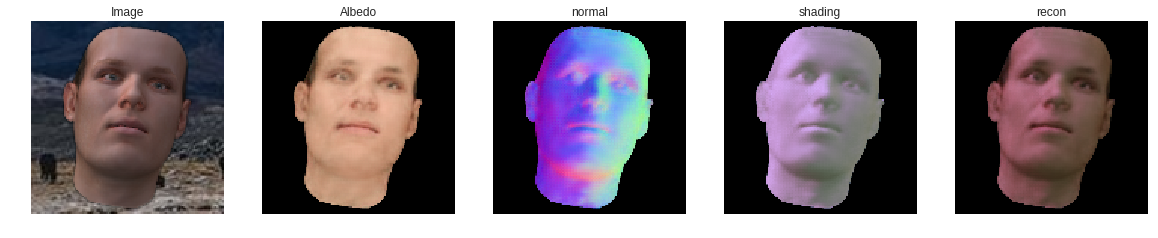

In [0]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,5,figsize=(20, 4))

img = test_image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Image')

img = predicted_albedo
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Albedo')

img = predicted_normal
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('normal')

img = predicted_shading
axs[3].imshow(img)
axs[3].axis('off')
axs[3].set_title('shading')

img = predicted_recon
axs[4].imshow(img)
axs[4].axis('off')
axs[4].set_title('recon')

(-0.5, 127.5, 127.5, -0.5)

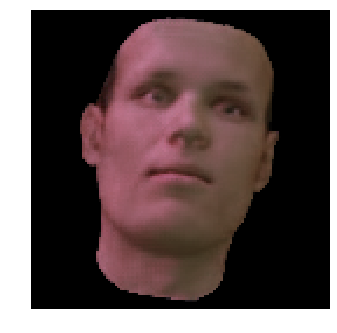

In [0]:
img = predicted_recon
plt.imshow(img)
plt.axis('off')

In [0]:
from google.colab import files
files.upload()
!ls

Saving 17_face.png to 17_face.png
17_face.png  9_face.png  adc.json  sample_data		SyntheticData
17_mask.png  9_mask.png  drive	   Syn_data_medium.zip


In [0]:

input = []
mask1 = []

#inp = im.imread('inp.jpg')
im=io.imread('9_face.png')
input.append(skimage.transform.resize(im,(128,128))) 
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input.append(skimage.transform.resize(im,(128,128)))
input = np.asarray(input).astype(np.float32)
#input.append(np.array(inp))
#input.append(np.array(inp))
#input = np.array(input)

mk=io.imread('9_mask.png')

mask1.append(skimage.transform.resize(mk,(128,128))) 
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1.append(skimage.transform.resize(mk,(128,128)))
mask1 = np.asarray(mask1).astype(np.float32)

#mask1 = np.expand_dims(mask1, axis=3)
#mask1 = np.repeat(mask1,3,axis=3)
print(mask1.shape)

(10, 128, 128, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
test_data = {"images":input, "mask": mask1, "normals": normal_list[test_min_index:2], "albedos": albedo_list[test_min_index:2],\
             "lightings": light[test_min_index:2], "nlabel": normal_label[test_min_index:2],\
             "alabel": albedo_label[test_min_index:2], "mlabel": mask_label[test_min_index:2]}

In [0]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
  x=input_fn(test_data)[0],
  batch_size=10,
  num_epochs=1,
  shuffle=False)

In [0]:
predictions = list(estimator.predict(input_fn=predict_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./drive/Colab Notebooks/SFSNet/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
test_image = test_data["images"][0]
predicted_normal = np.clip(predictions[0]["normal"], 0, 1)
predicted_albedo = np.clip(predictions[0]["albedo"], 0, 1)
predicted_recon = np.clip(predictions[0]["recon"], 0, 1)
predicted_shading = np.clip(predictions[0]["shading"], 0, 1)

Text(0.5,1,'recon')

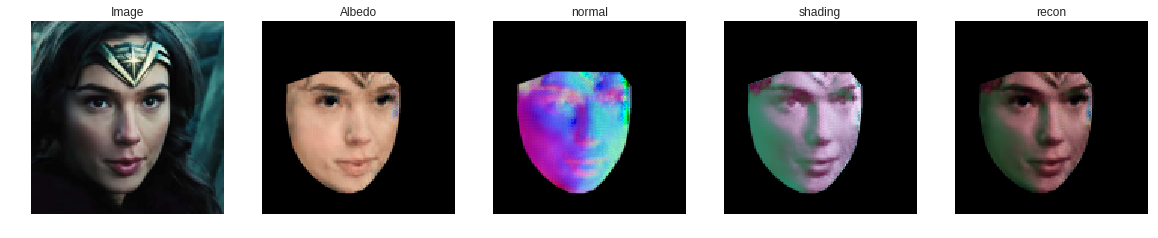

In [0]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,5,figsize=(20, 4))

img = test_image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Image')

img = predicted_albedo
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Albedo')

img = predicted_normal
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('normal')

img = predicted_shading
axs[3].imshow(img)
axs[3].axis('off')
axs[3].set_title('shading')

img = predicted_recon
axs[4].imshow(img)
axs[4].axis('off')
axs[4].set_title('recon')